# <div style="text-align: center"> Recurrent Neural Networks (RNN)</div>
#### <div style="text-align: right"> 2019.09.23 Monday</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Jaewoong Cho, Junhyung Ahn</div>

**실습목표**
- Simple RNN 생성하기
- RNN을 훈련하여 시계열 예측하기 
- Long Short-Term Memory (LSTM)
- LSTM을 훈련하여 문장의 다음 글자 예측하기

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 1-A. BasicRNNCell 함수 사용하여 RNN 생성하기

In [3]:
# h0 = y0
n_steps = 1
input_dim= 3
output_dim = 5

X = tf.placeholder(tf.float32, [None,input_dim])


with tf.variable_scope("static_rnn1", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    outputs, states = tf.nn.static_rnn(cell=basic_cell, 
                                       inputs=[X], 
                                       dtype=tf.float32,)

X_batch  = np.array([[0,1,2],    
                     [3,4,5],    
                     [6,7,8],    
                     [9,0,1]])    

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs, states], 
                                       feed_dict= {X: X_batch})

print("Output: \n {} \n".format(output_vals))
print("States: \n {}\n".format(states_val))
print("Output == States? \n {}".format(output_vals==states_val))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Output: 
 [array([[-0.48432443,  0.92095673,  0.41449896,  0.9176296 ,  0.6650218 ],
       [ 0.10040054,  0.9994508 , -0.12513809,  0.9979229 ,  0.99818385]

In [4]:
# 정적으로 타임 스텝 펼치기
X0 = tf.placeholder(tf.float32, [None, input_dim])
X1 =  tf.placeholder(tf.float32, [None, input_dim])

# 미니배치
X0_batch = np.array([[0,1,2],
                     [3,4,5],
                     [6,7,8],
                     [9,0,1]]) #t=0
X1_batch = np.array([[9,8,7],
                     [0,0,0],
                     [6,5,4],
                     [3,2,1]]) #t=1

with tf.variable_scope("static_rnn2", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    output_seqs, states = tf.contrib.rnn.static_rnn(cell=basic_cell,
                                                    inputs=[X0,X1],
                                                    dtype=tf.float32)
    Y0,Y1 = output_seqs

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    Y0_val, Y1_val = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1:X1_batch})
    state_val = sess.run(states, feed_dict={X0: X0_batch, X1:X1_batch})
    
print("Y0_val: \n{}".format(Y0_val))      # t=0에서 y 
print("Y1_val: \n{}".format(Y1_val))      # t=1에서 y 
print("State_val: \n{}".format(state_val)) # t=1에서의 h

Y0_val: 
[[-0.47445345  0.43002522  0.15316264  0.7389329  -0.36381605]
 [-0.9977807  -0.5638027   0.8786813   0.8817811   0.59713453]
 [-0.9999931  -0.9398437   0.988707    0.94876957  0.9423509 ]
 [-0.99984634 -0.99944854  0.6551978  -0.99960613  0.99013436]]
Y1_val: 
[[-0.9999999  -0.9981329   0.98718715  0.46542427  0.9983521 ]
 [-0.06999217 -0.5816204  -0.8537666  -0.06558075 -0.21551993]
 [-0.99995357 -0.9988854   0.7965357  -0.1555355   0.97823733]
 [-0.9670468  -0.9527892   0.8260328  -0.85571295  0.84784305]]
State_val: 
[[-0.9999999  -0.9981329   0.98718715  0.46542427  0.9983521 ]
 [-0.06999217 -0.5816204  -0.8537666  -0.06558075 -0.21551993]
 [-0.99995357 -0.9988854   0.7965357  -0.1555355   0.97823733]
 [-0.9670468  -0.9527892   0.8260328  -0.85571295  0.84784305]]


In [106]:
# 가변 길이 시퀀스 입력
n_steps = 3

X = tf.placeholder(tf.float32, [None, n_steps, input_dim])
seq_length  = tf.placeholder(tf.int32, [None])
with tf.variable_scope("dynamic_rnn", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    outputs, states = tf.nn.dynamic_rnn(cell=basic_cell, 
                                        inputs=X, 
                                        dtype=tf.float32,
                                        sequence_length=seq_length)

X_batch  = np.array([
                     # t = 0  # t = 1   #t=2
                     [[0,1,2],[9,8,7]], [4,5,3],    # 샘플 0
                     [[3,4,5],[10,10,10], [1,4,2]],    # 샘플 1
                     [[6,7,8],[6,5,4], [9,5,3]],    # 샘플 2
                     [[9,0,1],[3,2,1], [2,0,4]]])   # 샘플 3

seq_length_batch = np.array([3,1,2,3])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs,states], feed_dict={X:X_batch, seq_length:seq_length_batch})
    
print("Output: \n {} \n".format(output_vals))
print("States: \n {}".format(states_val))

ValueError: setting an array element with a sequence.

In [8]:
# 가변 길이 시퀀스 입력
n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, input_dim])
seq_length  = tf.placeholder(tf.int32, [None])
with tf.variable_scope("dynamic_rnn", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    outputs, states = tf.nn.dynamic_rnn(cell=basic_cell, 
                                        inputs=X, 
                                        dtype=tf.float32,)
#                                         sequence_length=seq_length)

X_batch  = np.array([
                     # t = 0  # t = 1
                     [[0,1,2],[9,8,7]],    # 샘플 0
                     [[3,4,5],[10,10,10]],    # 샘플 1
                     [[6,7,8],[6,5,4]],    # 샘플 2
                     [[9,0,1],[3,2,1]]])   # 샘플 3

seq_length_batch = np.array([2,1,2,2])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs,states], feed_dict={X:X_batch, seq_length:seq_length_batch})
    
print("Output: \n {} \n".format(output_vals))
print("States: \n {}".format(states_val))

Output: 
 [[[-0.0604566   0.38035932  0.10598546  0.7667127  -0.9420088 ]
  [-0.6419694  -0.9999652   0.95841473  1.         -1.0000001 ]]

 [[-0.12718588 -0.8129389   0.60680103  0.9999551  -0.9999465 ]
  [-0.56996757 -0.99996775  0.95426613  1.         -1.        ]]

 [[-0.19278342 -0.9904872   0.8620573   1.         -0.99999994]
  [-0.37662303 -0.99876446  0.7290086   0.9999997  -0.999709  ]]

 [[ 0.9823813  -0.99969405  0.6322161   0.9999738  -0.4786485 ]
  [ 0.18802795 -0.99100214 -0.01728841  0.9993115  -0.9015402 ]]] 

States: 
 [[-0.6419694  -0.9999652   0.95841473  1.         -1.0000001 ]
 [-0.56996757 -0.99996775  0.95426613  1.         -1.        ]
 [-0.37662303 -0.99876446  0.7290086   0.9999997  -0.999709  ]
 [ 0.18802795 -0.99100214 -0.01728841  0.9993115  -0.9015402 ]]


## 1-B. 시계열 예측을 위해 훈련하기

In [36]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  
    return np.expand_dims(series,2)
#     return series[..., np.newaxis].astype(np.float32)

In [46]:
a= np.random.randn(1,2)

In [47]:
a.shape

(1, 2)

In [52]:
b = np.expand_dims(a, axis=2)

In [50]:
print(a)

[[-0.66761255 -0.49007849]]


In [53]:
print(b)

[[[-0.66761255]
  [-0.49007849]]]


In [57]:
b.shape

(1, 2, 1)

In [59]:
b.squeeze().shape

(2,)

In [58]:
np.reshape(a, newshape=(1,2,1)).shape

(1, 2, 1)

In [45]:
np.reshape(a, newshape=(1,2,1))

array([[[-0.09000604],
        [ 1.22417246]]])

In [37]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

In [38]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [39]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

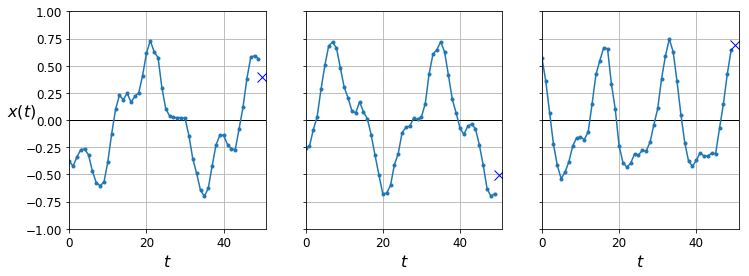

In [62]:
def plot_series(series, 
                y=None, 
                y_pred=None, 
                x_label="$t$", 
                y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10, label='Actual')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro",label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1
                         ,ncols=3, 
                         sharey=True,
                         figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### 1. Simple RNN

In [14]:
np.random.seed(42)

simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

simple_rnn_model.compile(loss="mse", optimizer="adam")
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=20, 
                     validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 369us/sample - loss: 0.0297 - val_loss: 0.0094
Epoch 2/20
7000/7000 [==============================] - 2s 260us/sample - loss: 0.0073 - val_loss: 0.0058
Epoch 3/20
7000/7000 [==============================] - 2s 250us/sample - loss: 0.0052 - val_loss: 0.0044
Epoch 4/20
7000/7000 [==============================] - 2s 276us/sample - loss: 0.0043 - val_loss: 0.0038
Epoch 5/20
7000/7000 [==============================] - 2s 259us/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 6/20
7000/7000 [==============================] - 2s 275us/sample - loss: 0.0035 - val_loss: 0.0031
Epoch 7/20
7000/7000 [==============================] - 2s 334us/sample - loss: 0.0033 - val_loss: 0.0031
Epoch 8/20
7000/7000 [==============================] - 2s 272us/sample - loss: 0.0032 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 2s 279us/sample - loss: 0.0031 - val_loss: 0.002

In [15]:
def plot_loss_curves(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

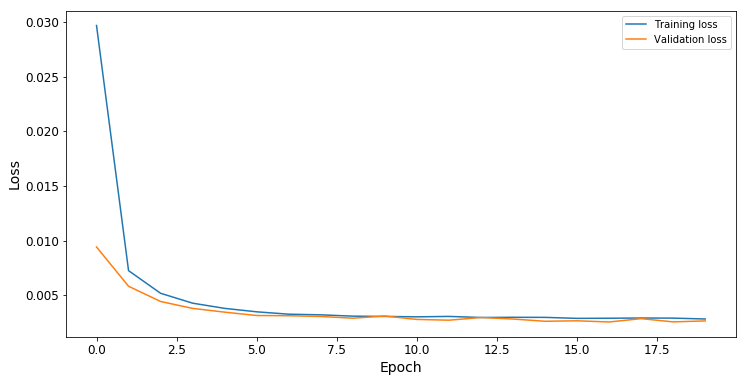

In [16]:
plot_loss_curves(simple_rnn_history)

In [17]:
simple_rnn_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 132us/sample - loss: 0.0028


0.00275010147690773

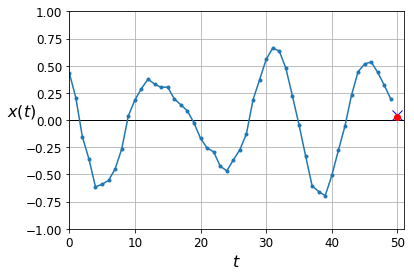

In [18]:
simple_rnn_y_pred = simple_rnn_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], simple_rnn_y_pred[0, 0])
plt.show()

In [19]:
print("Simple RNN Error: {}".format(y_test[0,0] - simple_rnn_y_pred[0,0]))

Simple RNN Error: 0.020383473485708237


###  2. LSTM

In [63]:
k_init = keras.initializers.Constant(value=0.1)
b_init = keras.initializers.Constant(value=0)
r_init = keras.initializers.Constant(value=0.1)

units = 1

inputs1 = keras.layers.Input(shape=(3, 2))
lstm1 = keras.layers.LSTM(units, return_sequences=True, kernel_initializer=k_init, bias_initializer=b_init, recurrent_initializer=r_init)(inputs1)
model = keras.models.Model(inputs=inputs1, outputs=lstm1)

data = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3]).reshape((1,3,2))

output = model.predict(data)
print(output, output.shape)

[[[0.00767819]
  [0.01597687]
  [0.02480671]]] (1, 3, 1)


In [64]:
inputs1 = keras.layers.Input(shape=(3, 2))
lstm1 = keras.layers.LSTM(units, kernel_initializer=k_init, bias_initializer=b_init, recurrent_initializer=r_init)(inputs1)
model = keras.models.Model(inputs=inputs1, outputs=lstm1)

data = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3]).reshape((1,3,2))

preds = model.predict(data)
print(preds, preds.shape)

[[0.02480671]] (1, 1)


array([[[0.1, 0.2],
        [0.3, 0.1],
        [0.2, 0.3]]])

In [66]:
np.random.seed(42)

lstm_model = keras.models.Sequential([
    keras.layers.LSTM(units=20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

lstm_model.compile(loss="mse", optimizer="adam")
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0690 - val_loss: 0.0300
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0262 - val_loss: 0.0218
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0120 - val_loss: 0.0097
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0071 - val_loss: 0.0050
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0043 - val_loss: 0.0034
Epoch 7/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0035 - val_loss: 0.0031
Epoch 8/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0033 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0031 - val_loss: 0.0029
Epoch 10/20


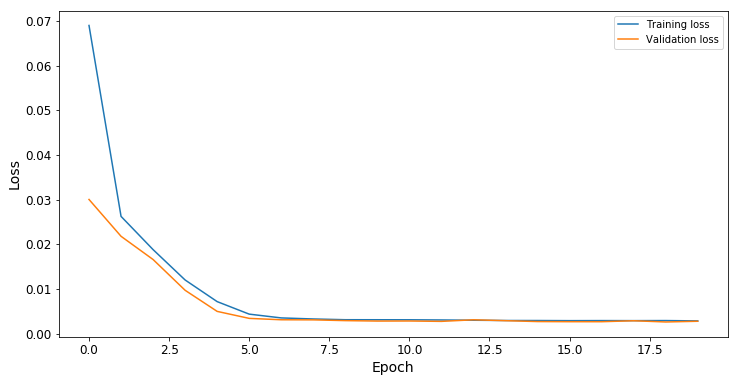

In [67]:
plot_loss_curves(lstm_history)

In [68]:
lstm_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 271us/sample - loss: 0.0031


0.0030691268322989343

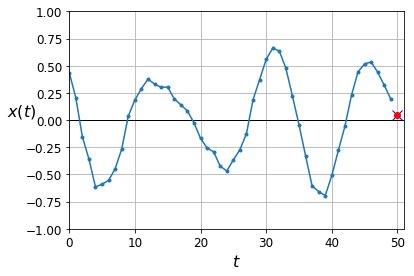

In [69]:
lstm_y_pred = lstm_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], lstm_y_pred[0, 0])
plt.show()

In [70]:
print("LSTM Error: {}".format(y_test[0,0] - lstm_y_pred[0,0]))

LSTM Error: -0.003457290285310749


## 1-C. LSTM 이용하여 다음 글자 예측하기

In [72]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()
    

In [73]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [77]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [78]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [79]:
max_id = len(tokenizer.word_index) 
dataset_size = tokenizer.document_count 

In [83]:
max_id,dataset_size

(39, 1115394)

In [82]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 1 // 100

In [96]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [97]:
print(dataset)

<DatasetV1Adapter shapes: (), types: tf.int64>


In [85]:
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.repeat().window(window_length, shift=1, 
                                  drop_remainder=True)

In [86]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [87]:
np.random.seed(42)

In [94]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

print(dataset)

<DatasetV1Adapter shapes: ((?, ?, ?, 39), (?, ?, ?)), types: (tf.float32, tf.int64)>


In [ ]:
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [89]:
dataset = dataset.map(lambda X_batch, Y_batch: 
                      (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [90]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, dropout=0.5, return_sequences=True, 
                      input_shape=[None, max_id]),
    keras.layers.LSTM(20, dropout=0.5, return_sequences=True),
    keras.layers.Dense(max_id, activation="softmax")
])

lstm_model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam")
lstm_history = lstm_model.fit(dataset, 
                    steps_per_epoch=train_size // batch_size, 
                    epochs=10)

Epoch 1/10
348/348 [==============================] - 49s 142ms/step - loss: 3.1400
Epoch 2/10
348/348 [==============================] - 47s 136ms/step - loss: 2.9750
Epoch 3/10
348/348 [==============================] - 48s 137ms/step - loss: 2.8325
Epoch 4/10
348/348 [==============================] - 47s 136ms/step - loss: 2.7269
Epoch 5/10
348/348 [==============================] - 46s 133ms/step - loss: 2.6523
Epoch 6/10
348/348 [==============================] - 46s 132ms/step - loss: 2.5851
Epoch 7/10
348/348 [==============================] - 47s 135ms/step - loss: 2.5361
Epoch 8/10
348/348 [==============================] - 47s 135ms/step - loss: 2.4960
Epoch 9/10
348/348 [==============================] - 47s 136ms/step - loss: 2.4680
Epoch 10/10
348/348 [==============================] - 46s 132ms/step - loss: 2.4427


In [91]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [102]:
X_new = preprocess(["How are yo"])
sess = tf.Session()
with sess.as_default():
    X_new = X_new.eval()

In [105]:
lstm_Y_pred = lstm_model.predict_classes(X_new)
tokenizer.sequences_to_texts(lstm_Y_pred + 1)[0][-1]

'u'